# Qiskit Circuit Session with Kevin Krsulich on the usage of transpiler 
from [link](https://youtu.be/2T3163VjvWQ)

In [1]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
%matplotlib inline
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### 3-qubit GHZ state 
$\vert \Psi\rangle = \frac{1}{\sqrt{2}}\left(\vert 0\rangle\vert 0\rangle\vert 0\rangle + \vert 1\rangle\vert 1\rangle\vert 1\rangle \right)$

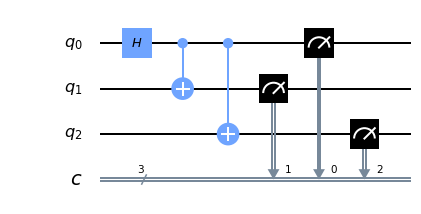

In [2]:
qc_ghz = QuantumCircuit(3, 3)
qc_ghz.h(0)
qc_ghz.cx(0, 1)
qc_ghz.cx(0, 2)
qc_ghz.measure([0, 1, 2], [0, 1, 2])
qc_ghz.draw(output='mpl')

Simulating the GHZ state using a quantum simulator

In [3]:
qobj_ghz_simulator = compiler.assemble(qc_ghz)
aer_job_ghz = Aer.get_backend('qasm_simulator').run(qobj_ghz_simulator)

In [4]:
aer_job_ghz.status()

<JobStatus.DONE: 'job has successfully run'>

In [5]:
aer_job_ghz.result().get_counts()

{'000': 506, '111': 518}

Trying to run the curcuit on real quantum device (ibmq_vigo)

In [6]:
provider = IBMQ.get_provider('ibm-q')
ibmq_vigo = provider.get_backend('ibmq_vigo')

In [7]:
qobj_ghz_device = compiler.assemble(qc_ghz)
ghz_job = ibmq_vigo.run(qobj_ghz_device)

In [8]:
ghz_job.status()

<JobStatus.ERROR: 'job incurred error'>

In [9]:
ghz_job.error_message()

"The Qobj uses gates (['h']) that are not among the basis gates (['u1', 'u2', 'u3', 'cx', 'id']). Error code: 1106."

In [10]:
ibmq_vigo

<IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>

#### Problem:
We get an error because the ibmq_vigo device topology does not support a two qubit gate between qubits 0 and 1 

#### Solution:
Therefore, we use the "transpile" feature to transform and compile our GHZ circuit into an equivalent quantum circuit that is supported by the topology of the ibmq_vigo device. 

In [11]:
tqc_ghz_vigo = transpile(qc_ghz, ibmq_vigo)
tqc_ghz_vigo.draw()

┌───┐ ░       ┌─┐
      q_2 -> 0 ────────────────────────────────┤ X ├─░───────┤M├
                           ┌───┐     ┌───┐     └─┬─┘ ░ ┌─┐   └╥┘
      q_1 -> 1 ────────────┤ X ├──■──┤ X ├──■────■───░─┤M├────╫─
               ┌──────────┐└─┬─┘┌─┴─┐└─┬─┘┌─┴─┐      ░ └╥┘┌─┐ ║ 
      q_0 -> 2 ┤ U2(0,pi) ├──■──┤ X ├──■──┤ X ├──────░──╫─┤M├─╫─
               └──────────┘     └───┘     └───┘      ░  ║ └╥┘ ║ 
ancilla_0 -> 3 ──────────────────────────────────────░──╫──╫──╫─
                                                     ░  ║  ║  ║ 
ancilla_1 -> 4 ──────────────────────────────────────░──╫──╫──╫─
                                                     ░  ║  ║  ║ 
          c_0: ═════════════════════════════════════════╩══╬══╬═
                                                           ║  ║ 
          c_1: ════════════════════════════════════════════╩══╬═
                                                              ║ 
          c_2: ═══════════════════════════════════════════════╩═

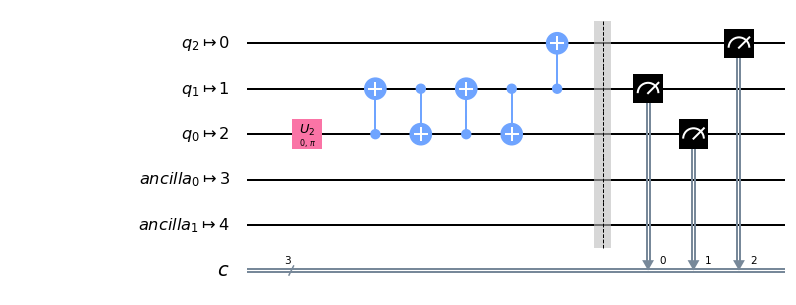

In [12]:
tqc_ghz_vigo.draw(output='mpl')

In [14]:
tqc_ghz_vigo_qobj_device = compiler.assemble(tqc_ghz_vigo)
tqc_ghz_vigo_job = ibmq_vigo.run(tqc_ghz_vigo_qobj_device)
job_monitor(tqc_ghz_vigo_job)

Job Status: job has successfully run


In [15]:
tqc_ghz_vigo_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [16]:
tqc_ghz_vigo_job.result().get_counts()

{'011': 25,
 '001': 6,
 '010': 16,
 '111': 380,
 '110': 15,
 '000': 530,
 '100': 10,
 '101': 42}

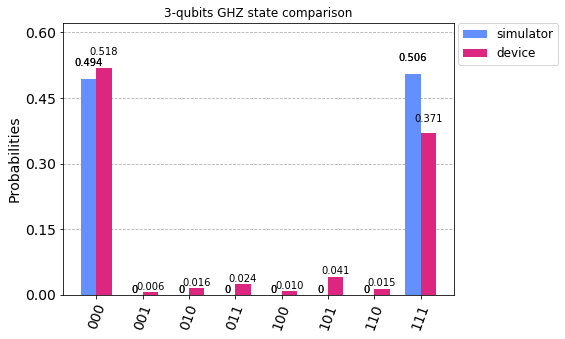

In [17]:
plot_histogram([aer_job_ghz.result().get_counts(), tqc_ghz_vigo_job.result().get_counts()],
              legend=['simulator', 'device'], title="3-qubits GHZ state comparison")

#### Optimization:
Optimizing the transpiling using (optimization_level=3)

In [18]:
tqc_ghz_vigo_opt = transpile(qc_ghz, ibmq_vigo, optimization_level=3)
tqc_ghz_vigo_opt.draw()

┌───┐     ┌─┐      
      q_1 -> 0 ────────────┤ X ├─────┤M├──────
               ┌──────────┐└─┬─┘     └╥┘┌─┐   
      q_0 -> 1 ┤ U2(0,pi) ├──■────■───╫─┤M├───
               └──────────┘     ┌─┴─┐ ║ └╥┘┌─┐
      q_2 -> 2 ─────────────────┤ X ├─╫──╫─┤M├
                                └───┘ ║  ║ └╥┘
ancilla_0 -> 3 ───────────────────────╫──╫──╫─
                                      ║  ║  ║ 
ancilla_1 -> 4 ───────────────────────╫──╫──╫─
                                      ║  ║  ║ 
          c_0: ═══════════════════════╬══╩══╬═
                                      ║     ║ 
          c_1: ═══════════════════════╩═════╬═
                                            ║ 
          c_2: ═════════════════════════════╩═

## Random Circuits

In [19]:
from qiskit.circuit.random import random_circuit
import numpy as np

random_circuits = {input_depth: [random_circuit(5, int(input_depth), measure=True, seed=seed)
                                for seed in range(10)]
                  for input_depth in np.linspace(1, 100, num=10)}

In [20]:
type(random_circuits)

dict

In [21]:
random_circuits.keys()

dict_keys([1.0, 12.0, 23.0, 34.0, 45.0, 56.0, 67.0, 78.0, 89.0, 100.0])

In [22]:
random_circuits[12.0][0].draw()

┌───────────┐        ┌───┐                          ┌───┐     »
q_0: ┤ RX(5.735) ├──────■─┤ H ├────────────────────X─────┤ Z ├─────»
     └───┬───┬───┘      │ └───┘┌───┐               │     └───┘     »
q_1: ────┤ H ├──────────X──────┤ X ├───────────────X───────■───────»
         └───┘    ┌───┐ │ ┌───┐└─┬─┘┌────────────┐ │     ┌─┴─┐     »
q_2: ──────■──────┤ H ├─┼─┤ T ├──┼──┤ RZ(6.1628) ├─┼─────┤ Y ├─────»
         ┌─┴─┐    └─┬─┘ │ ├───┤  │  └─────┬──────┘ │     └───┘     »
q_3: ────┤ X ├──────■───┼─┤ X ├──┼────────■────────┼───────■───────»
         └─┬─┘          │ └───┘  │                 │ ┌─────┴──────┐»
q_4: ──────■────────────X────────■─────────────────■─┤ RZ(1.9493) ├»
                                                     └────────────┘»
c_0: ══════════════════════════════════════════════════════════════»
                                                                   »
c_1: ══════════════════════════════════════════════════════════════»
                                                                   »
c_2: ══════════════════════════════════════════════════════════════»
                                                                   »
c_3: ══════════════════════════════════════════════════════════════»
                                                                   »
c_4: ══════════════════════════════════════════════════════════════»
                                                                   »
«            ┌───────────┐                                      »
«q_0: ───────┤ RZ(3.591) ├──────────────X────────────────■───■──»
«            └─────┬─────┘              │                │ ┌─┴─┐»
«q_1: ─────────────■────────────────────┼─────────■───X──┼─┤ X ├»
«                ┌───┐                  │       ┌─┴─┐ │  │ └─┬─┘»
«q_2: ───────────┤ S ├──────────────────┼───────┤ X ├─X──┼───┼──»
«                └───┘                  │       └───┘ │  │   │  »
«q_3: ─────────────■────────────────────X─────────────┼──■───┼──»
«     ┌────────────┴─────────────┐┌────────────┐      │      │  »
«q_4: ┤ U3(2.1232,2.4606,5.5938) ├┤ U1(5.2317) ├──────■──────■──»
«     └──────────────────────────┘└────────────┘                »
«c_0: ══════════════════════════════════════════════════════════»
«                                                               »
«c_1: ══════════════════════════════════════════════════════════»
«                                                               »
«c_2: ══════════════════════════════════════════════════════════»
«                                                               »
«c_3: ══════════════════════════════════════════════════════════»
«                                                               »
«c_4: ══════════════════════════════════════════════════════════»
«                                                               »
«     ┌───────────────────────────┐                         ┌───┐┌─┐         »
«q_0: ┤ U3(2.2941,0.66285,3.9528) ├───────────X─────────────┤ X ├┤M├─────────»
«     └─────────────┬─────────────┘           │      ┌─────┐└─┬─┘└╥┘┌─┐      »
«q_1: ──────────────■─────────────────────────X──────┤ TDG ├──┼───╫─┤M├──────»
«                                  ┌───┐      │      └┬───┬┘  │   ║ └╥┘┌─┐   »
«q_2: ────────■────────────────────┤ X ├──────■───────┤ H ├───┼───╫──╫─┤M├───»
«             │1.8761.8768         └─┬─┘             ┌┴───┴┐  │   ║  ║ └╥┘┌─┐»
«q_3: ────────■──────────────────────■───■───────────┤ TDG ├──┼───╫──╫──╫─┤M├»
«                                    │   │zz(5.9624) └─────┘  │   ║  ║  ║ └╥┘»
«q_4: ───────────────────────────────■───■────────────────────■───╫──╫──╫──╫─»
«                                                                 ║  ║  ║  ║ »
«c_0: ════════════════════════════════════════════════════════════╩══╬══╬══╬═»
«                                                                    ║  ║  ║ »
«c_1: ═══════════════════════════════════════════════════════════════╩══╬══╬═»
«                                                               

In [23]:
transpile(random_circuits[12.0][0], ibmq_vigo, optimization_level=3).depth()

165

In [24]:
random_circuits[12.0][0].depth()

13

We see that taking a depth 13 random quantum circuit and optimizing it to fit the ibmq_vigo device result in an equivalent circuit with depth of 209 !!!

### Changing basis of universal gates using transpile

Toffoli gate:

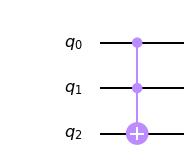

In [25]:
ccx_circ = QuantumCircuit(3)
ccx_circ.ccx(0, 1, 2)
ccx_circ.draw(output='mpl')

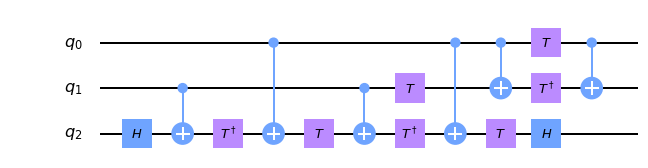

In [26]:
transpile(ccx_circ, basis_gates=['h', 't', 'tdg', 'cx']).draw(output='mpl')

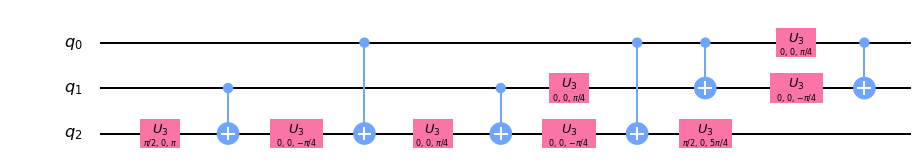

In [27]:
transpile(ccx_circ, basis_gates=['u3', 'cx']).draw(output='mpl')

Bernstein–Vazirani circuit:

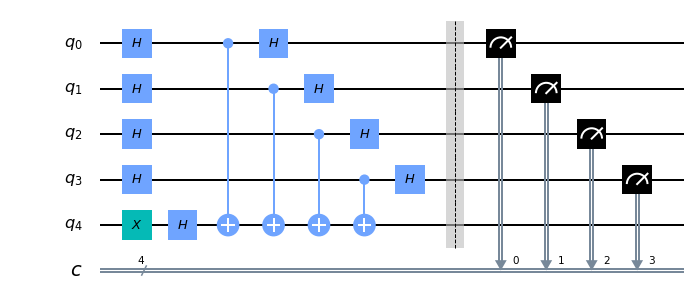

In [28]:
bv_circ = QuantumCircuit(5, 4)
bv_circ.x(4)
bv_circ.h(range(5))
bv_circ.cx(range(4), 4)
bv_circ.h(range(4))
bv_circ.barrier()
bv_circ.measure(range(4), range(4))
bv_circ.draw(output='mpl')

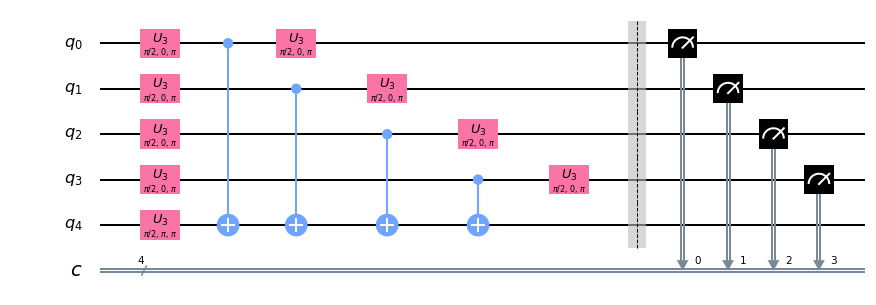

In [29]:
transpile(bv_circ, basis_gates=['u3', 'cx']).draw(output='mpl')

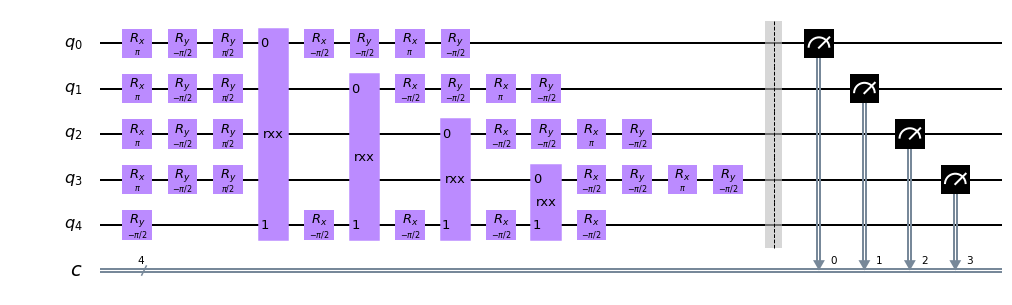

In [30]:
transpile(bv_circ, basis_gates=['rxx', 'ry', 'rx']).draw(output='mpl')

### Layout_method

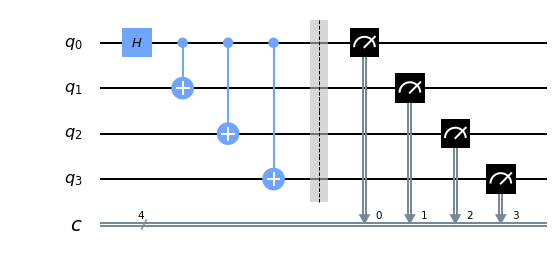

In [31]:
qc_ghz4 = QuantumCircuit(4, 4)
qc_ghz4.h(0)
qc_ghz4.cx(0, range(1, 4))
qc_ghz4.barrier()
qc_ghz4.measure(range(4), range(4))
qc_ghz4.draw(output='mpl')

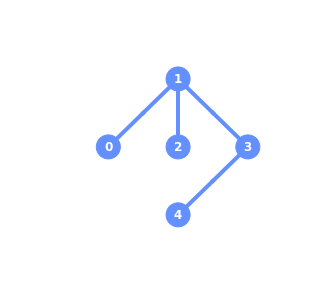

In [41]:
ibmq_ourense = provider.get_backend('ibmq_ourense')
visualization.plot_gate_map(ibmq_ourense)

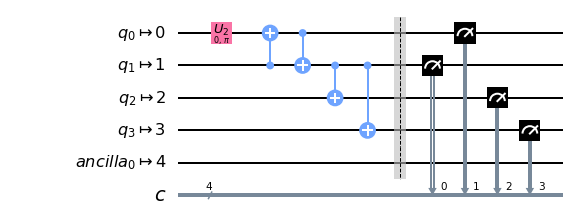

In [48]:
transpile(qc_ghz4, ibmq_ourense, layout_method='trivial').draw(output='mpl', scale=0.5)

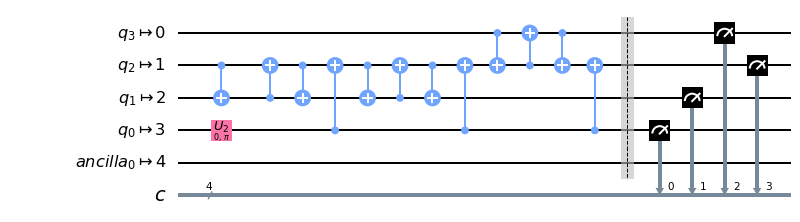

In [49]:
transpile(qc_ghz4, ibmq_ourense, layout_method='dense').draw(output='mpl', scale=0.5)

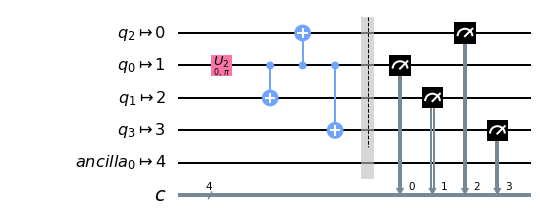

In [47]:
transpile(qc_ghz4, ibmq_ourense, layout_method='noise_adaptive').draw(output='mpl', scale=0.5)

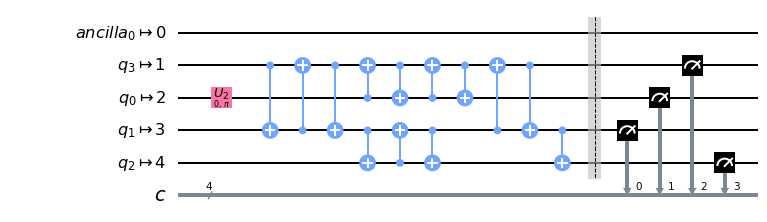

In [50]:
transpile(qc_ghz4, ibmq_ourense, initial_layout=[2, 3, 4, 1]).draw(output='mpl', scale=0.5)

### Routing